The attached .csv file contains berry production volume for a period of 235 weeks. The goal is to build a model to predict the next 10 weeks of productions using only the data contained in this file.

##### Below is the array with 10 forecasts using auto.arima:

array([56.84883333, 41.66139663, 28.45951339, 22.30365011,  9.16500186,
        5.94654455,  5.6341076 ,  5.68448461,  5.83694841,  5.98726002])

##### Based on the forecasts, functional teams can work together to propose strategies related to sales, marketing, inventory & product development.

This notebook contains:

- some exploratory analysis and seasonal decomposition of the time series
- strategies to deal with zeros in the data:
    - do nothing
    - replace with NaN
        - fbprophet handles NaN automatically, while auto.arima doesn't
    - remove zeros
        - potentially not feasible since total periods of zero vary year by year
        - would affect yearly the seasonality of the series
- forecasting:
    - train test split
    - visualizations of predictions vs. observations
    - packages used for modeling:
        - pmdarima (auto.arima): grid search to determine best paramters
        - fbprophet: provides a much faster implementation
    - model evaluation

- potential for improvements:
    - take into account ACF, PACF & stationarity when tuning parameters of SARIMAX
    - take into account domain knowledge or business contexts
    

In [126]:
%matplotlib inline
import pandas as pd
from fbprophet import Prophet
import numpy as np

import statsmodels.api as sm
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [127]:
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [128]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [129]:
berry = pd.read_excel("sample.xlsx", header=None, names=['volume'])

In [130]:
berry.head()

,volume
0,0.008826
1,0.014048
2,0.027507
3,0.076269
4,0.116793


Since no associated weekly timestamps accompany berry production volume, we can create a hypothetical time range spanning 235 weeks for illustrative purposes.

In [131]:
berry.index = pd.date_range("2015", freq="W", periods=235)

In [132]:
berry.index

DatetimeIndex(['2015-01-04', '2015-01-11', '2015-01-18', '2015-01-25',
               '2015-02-01', '2015-02-08', '2015-02-15', '2015-02-22',
               '2015-03-01', '2015-03-08',
               ...
               '2019-04-28', '2019-05-05', '2019-05-12', '2019-05-19',
               '2019-05-26', '2019-06-02', '2019-06-09', '2019-06-16',
               '2019-06-23', '2019-06-30'],
              dtype='datetime64[ns]', length=235, freq='W-SUN')

In [133]:
berry.head()

,volume
2015-01-04,0.008826
2015-01-11,0.014048
2015-01-18,0.027507
2015-01-25,0.076269
2015-02-01,0.116793


In [134]:
berry.tail()

,volume
2019-06-02,71.003803
2019-06-09,58.215202
2019-06-16,86.415625
2019-06-23,65.903872
2019-06-30,74.541997


In [135]:
berry.isnull().sum() # no missing values

volume    0
dtype: int64

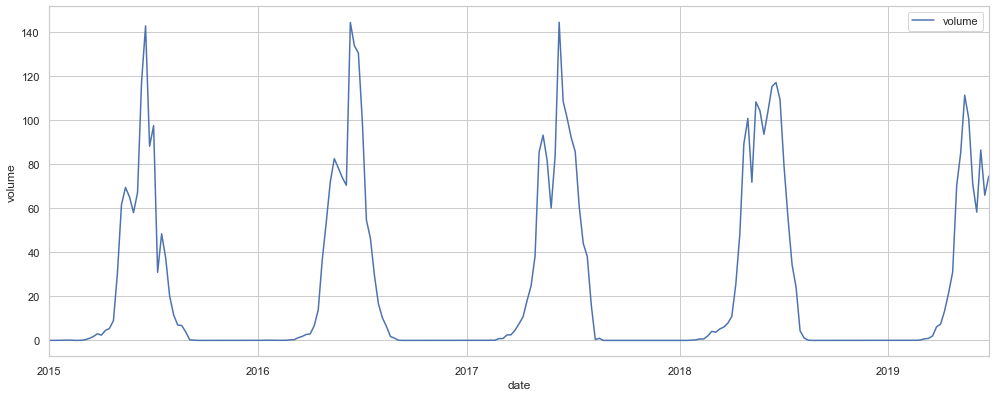

In [136]:
berry.plot(figsize=(15, 6))
plt.xlabel('date')
plt.ylabel('volume')
plt.show()

In the plot above, we observe an obvious seasonality pattern with peaks and lows (zeros). This agrees with the fact that berry production is seasonal in itself.

In [137]:
sum(berry.volume==0) # Within 235 periods, 73 are 0

73

A few things to look out for when visualizing a time series:
- seasonality: periodic pattern
- trend: upwards or downward slope
- noise: outlier points or missing values

We perform below time-series seasonal decomposition to decompose our time series into three distinct components: trend, seasonality, and noise.

The plot below clearly shows that the series is yearly seasonal.

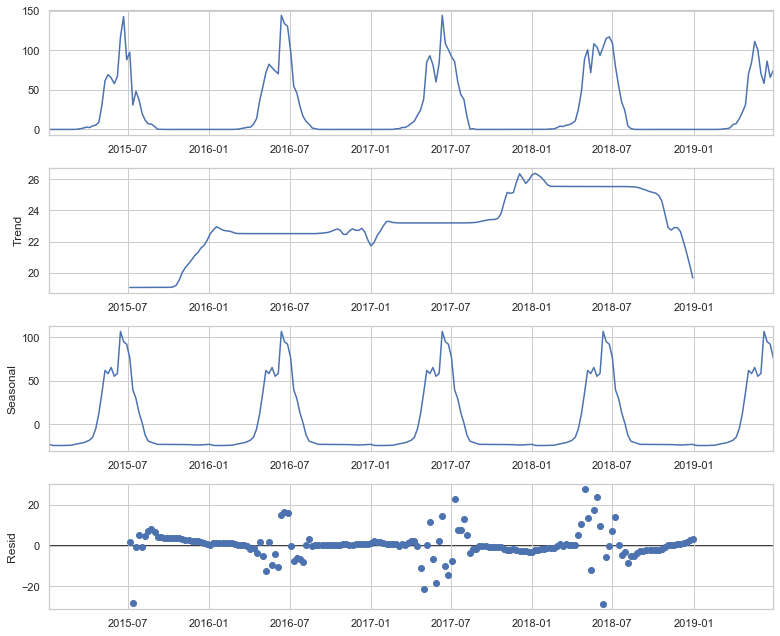

In [138]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(berry, model='additive')
fig = decomposition.plot()
plt.show()

A couple of potential approaches for forecasting time series data with zeros values:

- Croston's method (R packages: tsintermittent, forecast)
    - not demonstrated in this notebook
- truncating the time series by removing zeros
    - potentially not feasible since total periods of zero vary year by year
    - would affect yearly the seasonality of the series
- forecasting with zero values (do nothing to the time series)
- replace zero values with NAs 
    - depends on the model's ability to handle missing values

#### First, we try modeling directly on the original time series with zeros using two packages:

- pyramid-arima: performs a grid search over multiple values of p,d,q,P,D,Q using IC
- fbprophet

In [139]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [140]:
# splitting our time series into train and test sets
# recall we have 235 periods in our data, thus we can try train_size = 200
train, test = train_test_split(berry, train_size=200)

In [141]:
# Fit your model
# note: m parameter is the number of observations per seasonal cycle, in our case, 52 weeks per year
model = pm.auto_arima(train, seasonal=True, m=52)

In [142]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  200
Model:             SARIMAX(2, 0, 2)x(2, 0, [1], 52)   Log Likelihood                -774.790
Date:                              Sat, 30 Jan 2021   AIC                           1567.580
Time:                                      16:01:42   BIC                           1597.265
Sample:                                           0   HQIC                          1579.593
                                              - 200                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0459      0.105      0.439      0.661      -0.159       0.251
ar.L1          1.8863      0.062     30.388      0.000       1.765       2.008
ar.L2         -0.9052      0.060    -15.123      0.000      -1.023      -0.788
ma.L1         -1.2368      0.090    -13.768      0.000      -1.413      -1.061
ma.L2          0.2686      0.069      3.911      0.000       0.134       0.403
ar.S.L52       1.0270      0.613      1.676      0.094      -0.174       2.228
ar.S.L104     -0.1322      0.394     -0.336      0.737      -0.904       0.640
ma.S.L52      -0.5770      0.644     -0.897      0.370      -1.838       0.684
sigma2       128.4583     11.533     11.138      0.000     105.853     151.063
===================================================================================
Ljung-Box (Q):                       26.28   Jarque-Bera (JB):               286.68
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.93
Prob(H) (two-sided):                  0.92   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [143]:
# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

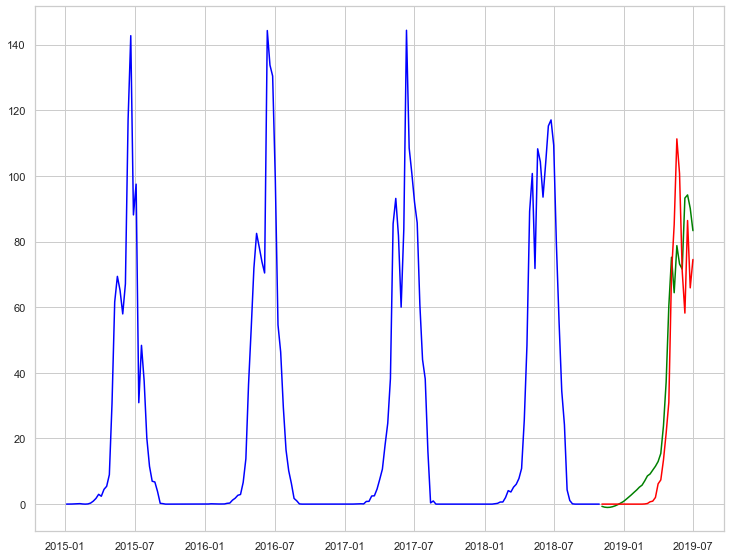

In [144]:
# Visualize the forecasts (blue=train, green=forecasts, red=test)
x = berry.index
plt.plot(x[:200], train, c='blue')
plt.plot(x[200:], forecasts, c='green')
plt.plot(x[200:], test, c='red')
plt.show()

We notice from the plot above that forecasts (green line) matched up reasonably well with the test data (red line). However, we do notice that first few forecasts are negative in value, which might be due to the long periods of zeros between peaks. It should affect us less if we're only interested in forecasting berry production volume in peak months.

Let's apply auto.arima on the entire data, and use it to predict the next 10 weeks of productions, which is the ultimate goal of this project.

In [145]:
model_full = pm.auto_arima(berry, seasonal=True, m=52)

In [146]:
model_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  235
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 52)   Log Likelihood                -913.509
Date:                              Sat, 30 Jan 2021   AIC                           1837.018
Time:                                      16:09:49   BIC                           1854.316
Sample:                                           0   HQIC                          1843.992
                                              - 235                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0075      0.830      1.213      0.225      -0.620       2.635
ar.L1          0.8127      0.033     24.793      0.000       0.748       0.877
ar.S.L52       0.7476      0.036     20.589      0.000       0.676       0.819
ma.S.L52      -0.1900      0.065     -2.915      0.004      -0.318      -0.062
sigma2       122.8091      7.240     16.964      0.000     108.620     136.998
===================================================================================
Ljung-Box (Q):                       26.02   Jarque-Bera (JB):               306.73
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             1.23
Prob(H) (two-sided):                  0.79   Kurtosis:                         8.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
forecasts = model_full.predict(10) 

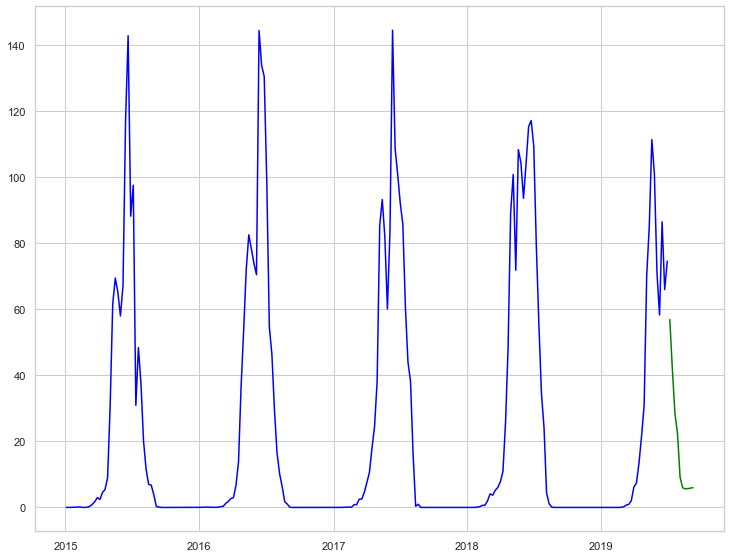

In [148]:
# Visualize the forecasts for 10 weeks into the future (blue=train, green=forecasts)
x = berry.index
x2 = pd.date_range('2019-07-07', freq="W", periods=10)
plt.plot(x, berry, c='blue')
plt.plot(x2, forecasts, c='green')
plt.show()

In the plot above, green line is our 10-week forecasts of berry productions. We see that this aligns reasonably well with production patterns of previous years.

##### Next we try a quick implementation of the fbprophet package.

In [149]:
df = pd.DataFrame({'ds':berry.index, 'y':berry.volume})
df.head()

,ds,y
2015-01-04,2015-01-04,0.008826
2015-01-11,2015-01-11,0.014048
2015-01-18,2015-01-18,0.027507
2015-01-25,2015-01-25,0.076269
2015-02-01,2015-02-01,0.116793


In [150]:
df.reset_index(drop=True, inplace=True)

In [151]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
ts_model = Prophet(interval_width=0.95)

In [152]:
ts_model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [153]:
# creatings 10 weekly dates into the future
future = ts_model.make_future_dataframe(periods=10, freq='w')
future.tail()

,ds
240,2019-08-11
241,2019-08-18
242,2019-08-25
243,2019-09-01
244,2019-09-08


In [154]:
len(future)

245

In [155]:
# Prophet relies on Markov chain Monte Carlo (MCMC) methods to generate its forecasts. MCMC is a stochastic process, 
# so values will be slightly different each time.

# note: yhat is our predictions

forecast = ts_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
240,2019-08-11,1.214376,-18.346071,19.882979
241,2019-08-18,-5.597860,-25.119362,12.920681
242,2019-08-25,-6.496626,-27.103458,12.842533
243,2019-09-01,-4.702011,-24.967955,13.839458
244,2019-09-08,-4.587175,-24.685051,13.229351


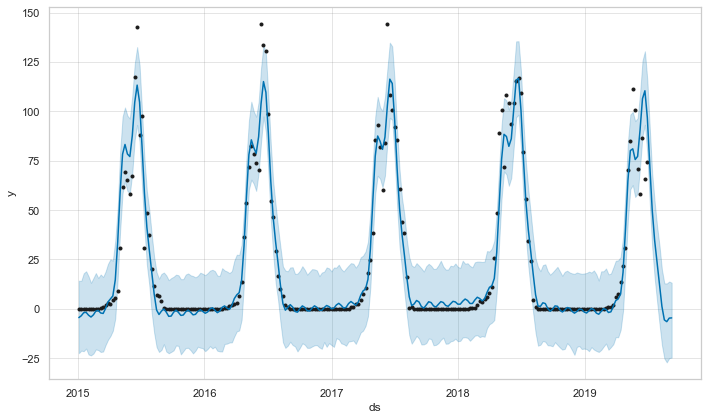

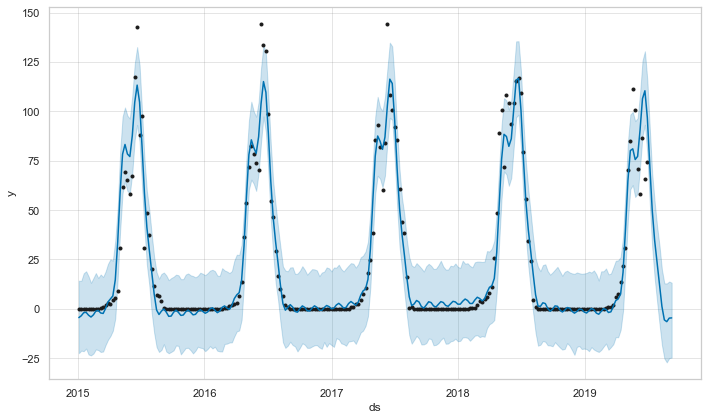

In [156]:
# Prophet plots the observed values of our time series (the black dots), the forecasted values 
# (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

ts_model.plot(forecast, uncertainty=True)

From the plot above, we see that the forecasted values align with our expectations, except that the last 4 predictions are negative. We can treat negative values as zeros in our context.

### Now we try repeating our analysis above for time series with zeors replaced by NAs

In [157]:
berry.replace(0, np.nan, inplace=True)

In [158]:
berry.isnull().sum() # now we have 73 nulls instead of zeros

volume    73
dtype: int64

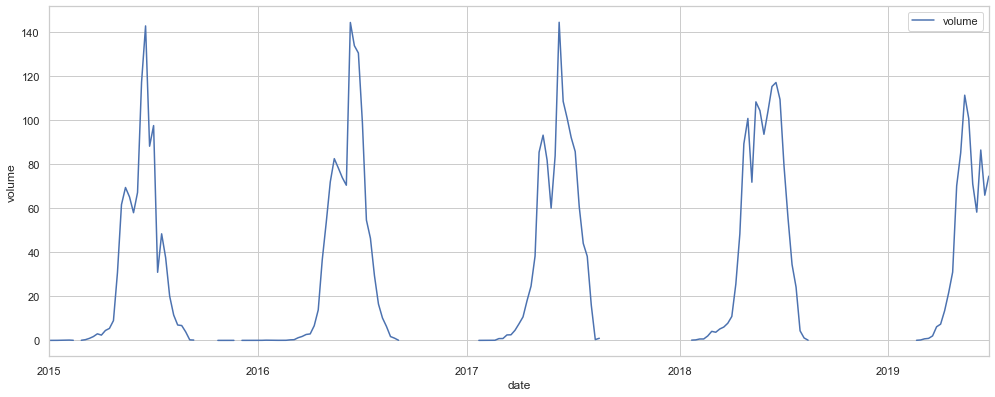

In [159]:
# we obeserve breaks below due to nulls
berry.plot(figsize=(15, 6))
plt.xlabel('date')
plt.ylabel('volume')
plt.show()

#### An attempt to fit shows that auto.arima doesn't handle np.nan values, while fbprophet does.

In [161]:
df = pd.DataFrame({'ds':berry.index, 'y':berry.volume})
df.reset_index(drop=True, inplace=True)

In [162]:
ts_model = Prophet(interval_width=0.95)
ts_model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [163]:
future = ts_model.make_future_dataframe(periods=10, freq='w')
future.tail()

,ds
240,2019-08-11
241,2019-08-18
242,2019-08-25
243,2019-09-01
244,2019-09-08


In [164]:
forecast = ts_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
240,2019-08-11,1.462076,-21.570927,25.034131
241,2019-08-18,-3.335211,-26.344629,17.992112
242,2019-08-25,-1.366758,-24.303808,22.119680
243,2019-09-01,0.878481,-21.444857,23.433662
244,2019-09-08,-1.839128,-23.827814,20.453713


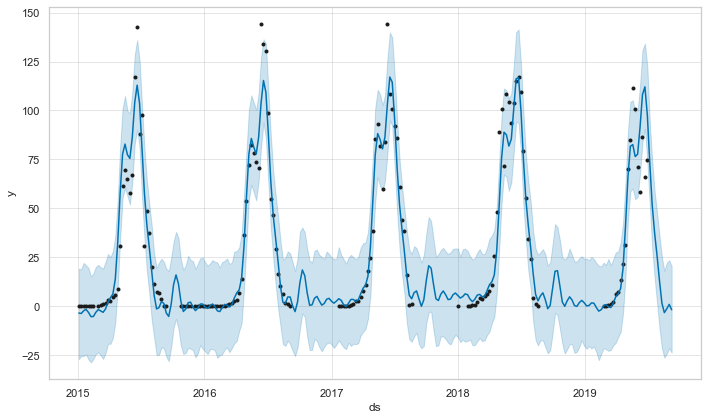

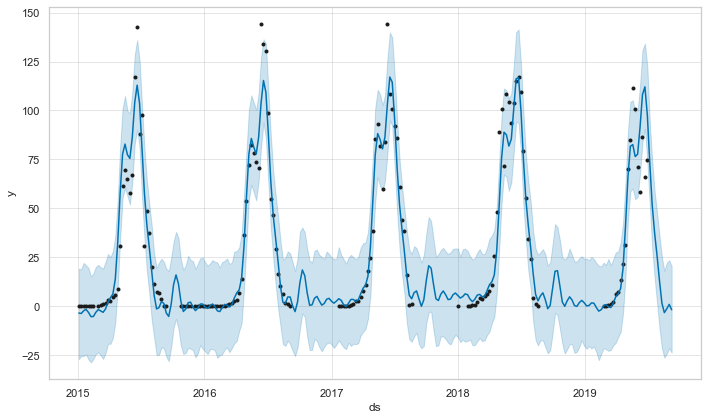

In [165]:
ts_model.plot(forecast, uncertainty=True)

From the plot above, the forecasts using fbprophet are reasonble despite the large number of NaN values.

#### A bit on ACF & PACF

In [167]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [168]:
berry = pd.read_excel("sample.xlsx", header=None, names=['volume'])
berry.index = pd.date_range("2015", freq="W", periods=235)

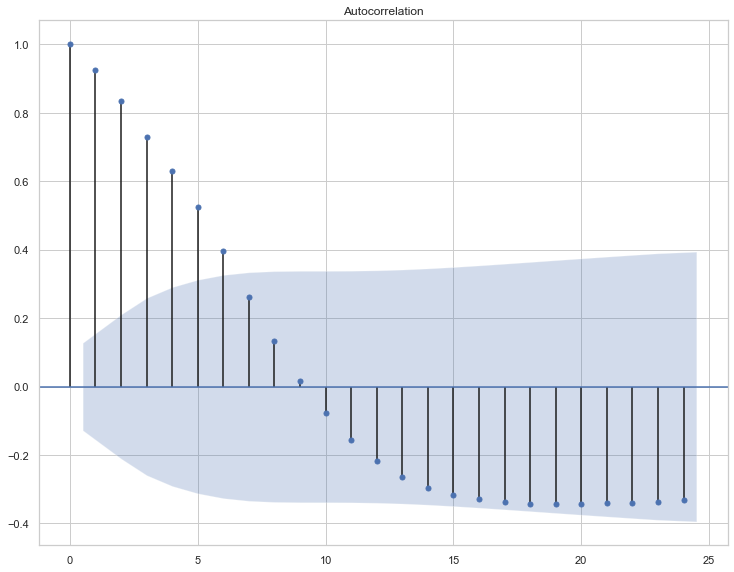

In [172]:
plot_acf(berry.volume)
plt.show()

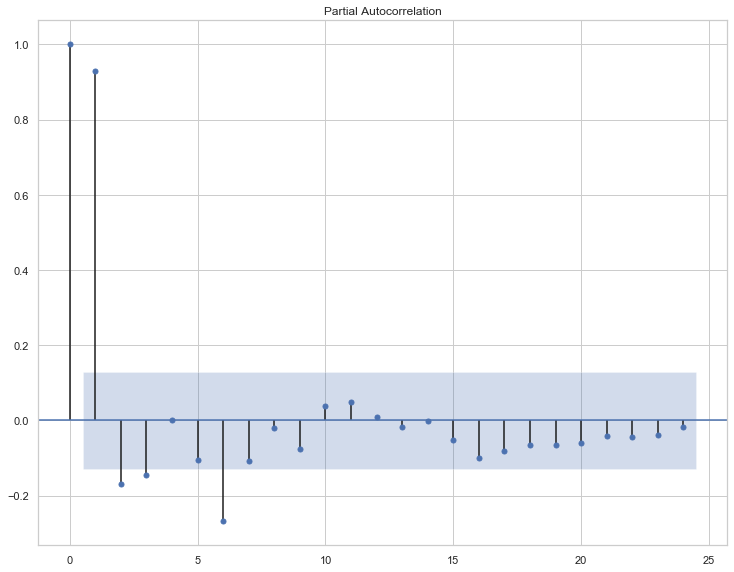

In [173]:
plot_pacf(berry.volume)
plt.show()